## AGAME Workflow

In [30]:
'''
This code includes all the steps needed to compute GPP maps with AGAME methodology:
The methodology includes the following steps:

1)Get icos tables (15 sites)
2)Get Sentinel-2 tables (15 sites)
3)Get ecosystem boundaries (15 sites)
4)Combine tables
5)Train XGBoost model
6)Evaluate XGBoost model
7)Create GPP maps (15 sites)
8)Creata uncertainty maps
'''

'\nThis code includes all the steps needed to compute GPP maps with AGAME methodology:\nThe methodology includes the following steps:\n\n1)Get icos tables (15 sites)\n2)Get Sentinel-2 tables (15 sites)\n3)Get ecosystem boundaries (15 sites)\n4)Combine tables\n5)Train XGBoost model\n6)Evaluate XGBoost model\n7)Create GPP maps (15 sites)\n8)Creata uncertainty maps\n'

In [31]:
import pandas as pd
import os
import seaborn as sns
from collections import Counter
import matplotlib.pyplot as plt
# from statsmodels.tsa.seasonal import STL

### Get icos tables (15 sites)

##### Load data

In [32]:
directory_insitu = r"Input\NETFLUX"
directory_sentinel = r"Input\S2"
directory_plot = r"Output\Plot"
directory_tables = r"Output\Tables"
aoi_file = r"Input\list_sites_without_Lonzee.xlsx"

df_initial = pd.read_excel(aoi_file)
df_training = df_initial

Estrees-Mons A28
Original number of columns: 350
Number of columns dropped: 2
Columns dropped: ['RECO_SR', 'RECO_SR_N']

Hohes Holz
Original number of columns: 354
Number of columns dropped: 2
Columns dropped: ['RECO_SR', 'RECO_SR_N']

Torgnon
Original number of columns: 334
Number of columns dropped: 2
Columns dropped: ['RECO_SR', 'RECO_SR_N']

Hyytiala
Original number of columns: 348
Number of columns dropped: 2
Columns dropped: ['RECO_SR', 'RECO_SR_N']

Klingenberg
Original number of columns: 350
Number of columns dropped: 2
Columns dropped: ['RECO_SR', 'RECO_SR_N']

Fontainebleau-Barbeau
Original number of columns: 370
Number of columns dropped: 2
Columns dropped: ['RECO_SR', 'RECO_SR_N']

Svartberget
Original number of columns: 348
Number of columns dropped: 2
Columns dropped: ['RECO_SR', 'RECO_SR_N']

Grillenburg
Original number of columns: 350
Number of columns dropped: 2
Columns dropped: ['RECO_SR', 'RECO_SR_N']

Number of columns available in all files: 332



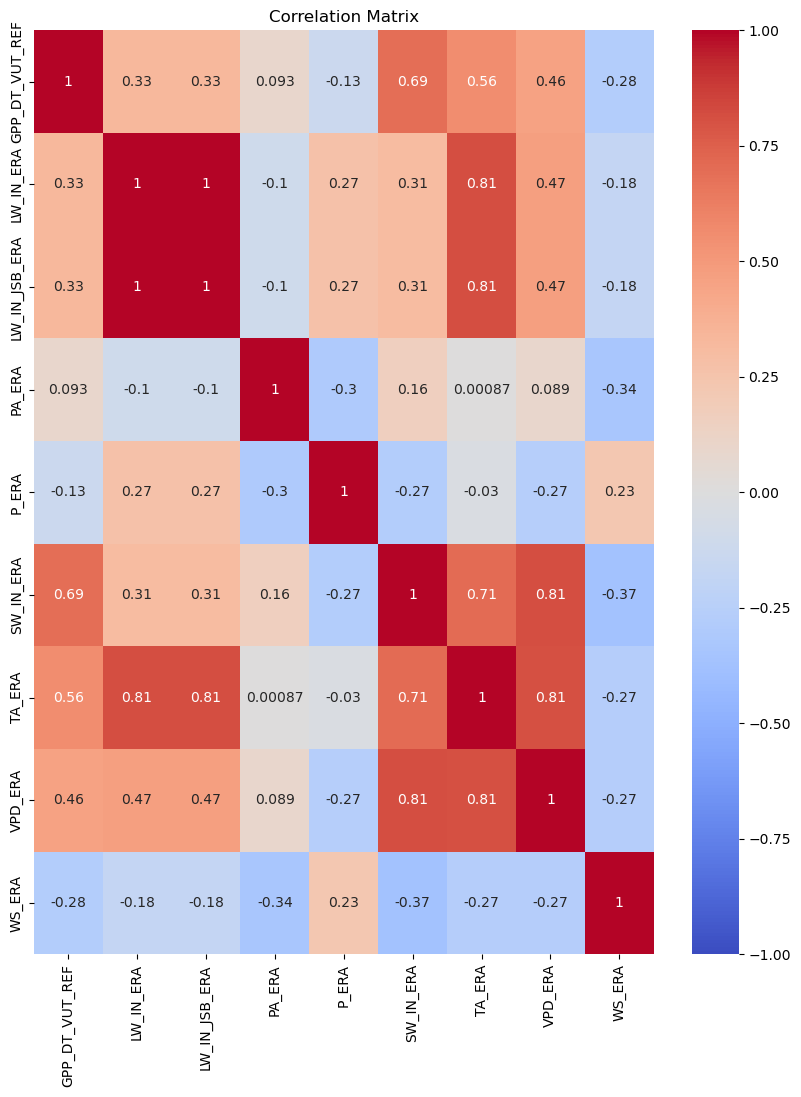

In [33]:
list_col = []
nan_cols = []
files = os.listdir(directory_insitu)

for index, row in df_training.iterrows():
    id = row['station id']
    site = row['site name']
    df = pd.read_csv(os.path.join(directory_insitu,f"ICOSETC_{id}_FLUXNET_DD_L2.csv"), na_values=-9999)

    original_num_columns = df.shape[1]
    cols_to_drop = df.columns[df.isna().all()].tolist()
    num_cols_dropped = len(cols_to_drop)

    print(site)
    print(f"Original number of columns: {original_num_columns}")
    print(f"Number of columns dropped: {num_cols_dropped}")
    print(f"Columns dropped: {cols_to_drop}\n")

    df_cleaned = df.drop(columns=cols_to_drop)
    list_col.extend(df_cleaned.columns.values.tolist())

counts = Counter(list_col)
list_col_in_all = set([item for item in list_col if counts[item] == (index+1)])
print(f"Number of columns available in all files: {len(list_col_in_all)}\n")

filtered_list_col_in_all = sorted([item for item in list_col_in_all if not (item.startswith('NEE') or 
                                                                            item.startswith('GPP') or 
                                                                            item.startswith('TIMESTAMP') or
                                                                            item.endswith('_QC') or 
                                                                            item.endswith('_METHOD') or 
                                                                            item.startswith('RECO'))])

combined_var = sorted([item for item in list_col_in_all  if item.endswith('_F')])
era_var = sorted([item for item in list_col_in_all  if item.endswith('_ERA')])
mds_var = sorted([item for item in list_col_in_all  if item.endswith('_MDS')])

# filtered_list_col_in_all.insert(0, 'GPP_DT_VUT_REF')
# df = df[filtered_list_col_in_all]

# combined_var.insert(0, 'GPP_DT_VUT_REF')
# df = df[combined_var]

era_var.insert(0, 'GPP_DT_VUT_REF')
df = df[era_var]

correlation_matrix = df.corr()

plt.figure(figsize=(10, 12))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.savefig(r'D:\Proyectos2024\Agame\Repository\vlabs\sen2gpp\Output\Plot\correlation_matrix_high_res_era_ref.png', dpi=300)  # Specify the path and DPI
plt.show()


In [34]:
col_ori =[ 
'TIMESTAMP',
 'latitude',
 'longitude',
 'elevation',
 'canopy_height',
 'month',
 'day',
 'biom_croplands', 
 'biom_dbf',
 'biom_enf', 
 'biom_grasslands',
 'winter', 
 'spring', 
 'summer', 
 'fall', 
 'GPP_DT_VUT_USTAR50'
 ]

col_to_decompose = [
 'B1',
 'B2',
 'B3',
 'B4',
 'B5',
 'B6',
 'B7',
 'B8',
 'B8A',
 'B9',
 'B11',
 'B12',
 'CLr',
 'EVI',
 'EVI2',
 'LSWI', 
 'MNDVI',
 'MNDWI',
 'NDII',
 'NDVI'
 ] + filtered_list_col_in_all

# FUNCTIONS
def additional_gobal(df,data):
    # Adding season data
    month_to_season = {
        1: 'winter', 2: 'winter', 3: 'spring',
        4: 'spring', 5: 'spring', 6: 'summer',
        7: 'summer', 8: 'summer', 9: 'fall',
        10: 'fall', 11: 'fall', 12: 'winter'
    }
    data['season'] = data['month'].map(month_to_season)
    df_encoded = pd.get_dummies(data, columns=['season'], prefix='season')
    data[['winter', 'spring', 'summer', 'fall']] = df_encoded[['season_winter', 'season_spring', 'season_summer', 'season_fall']].astype(int)
    data.drop(columns = ['season'], inplace = True)
    
    #Adding ecosystem type data
    df_encoded = pd.get_dummies(df, columns=['main ecosystem'], prefix='biom')
    df[['biom_croplands','biom_dbf','biom_enf','biom_grasslands']]=df_encoded[['biom_croplands', 'biom_dbf','biom_enf', 'biom_grasslands']].astype(int)
    data['biom_croplands'] = df.loc[df['station id'] == id, 'biom_croplands'].iloc[0]
    data['biom_dbf'] = df.loc[df['station id'] == id, 'biom_dbf'].iloc[0]
    data['biom_enf'] = df.loc[df['station id'] == id, 'biom_enf'].iloc[0]
    data['biom_grasslands'] = df.loc[df['station id'] == id, 'biom_grasslands'].iloc[0]
    return data

def decompose_df(df, site, directory_plot=directory_plot, col_ori=col_ori, col_to_decompose=col_to_decompose):
    
    df.set_index('TIMESTAMP', inplace=True)
    df = df.asfreq('D') 

    # Prepare DataFrames for each component
    df_all = pd.DataFrame(index=df.index)
    df_all[col_ori[1:]] = df[col_ori[1:]]
    df_all[col_to_decompose] = df[col_to_decompose] 

    # Apply STL decomposition to each column and store the results
    stl_results = {}
    for col in col_to_decompose:
        # Set 'period' to 90 for approximately three months of seasonality
        stl = STL(df[col], seasonal=13, period=90)  
        result = stl.fit()
        stl_results[col] = result
        
        # Store each component in its respective DataFrame
        df_all[col+"_trend"] = result.trend
        df_all[col+"_season"] = result.seasonal
        df_all[col+"_residual"] = result.resid  
    print(f"STL Decomposition done.")

    # Optionally, plot results for each component
    for col, result in stl_results.items():
        plt.figure(figsize=(15, 6))  # Initialize the figure
        plt.title(f"STL Decomposition for {col} of {site}")  # Optional: Add a title
        result.plot()
        full_path = os.path.join(directory_plot,"decomposed", f"{site}_{col}.png")  # Full path for the file
        plt.savefig(full_path)  # Save the figure
        plt.close()
    print(f"STL Decomposition plots saved")
    
    return df_all



In [1]:
insitu_cols = ['GPP_DT_VUT_USTAR50'] + filtered_list_col_in_all

for index, row in df_training.iterrows():
    id = row['station id']
    site = row['site name']
    sentinel = pd.read_csv(os.path.join(directory_sentinel,f"{site}_Vegetation_indices_processed.csv"), parse_dates=['date'])
    sentinel.rename(columns={'date':'TIMESTAMP'}, inplace=True)
    sentinel.set_index('TIMESTAMP', inplace=True)
    insitu = pd.read_csv(os.path.join(directory_insitu,f"ICOSETC_{id}_FLUXNET_DD_L2.csv"), index_col='TIMESTAMP', parse_dates=['TIMESTAMP'])
    insitu = insitu[insitu_cols]
    merged_input = pd.merge(left= insitu, right = sentinel, how="inner", left_index = True , right_index = True)
    merged_input['TIMESTAMP'] = pd.to_datetime(merged_input.index)
    start, end = merged_input['TIMESTAMP'].iloc[[0, -1]]
    merged_input['latitude'] = row['latitude']
    merged_input['longitude'] = row['longitude']
    merged_input['elevation'] = row['elevation']
    merged_input['canopy_height'] = row['canopy_height']
    merged_input['month'] = pd.DatetimeIndex(merged_input['TIMESTAMP']).month
    merged_input['day'] = pd.DatetimeIndex(merged_input['TIMESTAMP']).day
    merged_input = additional_gobal(df_training.copy(),merged_input)
    merged_input = decompose_df(merged_input,site)
    merged_input.to_csv(os.path.join(directory_tables,f"{site}_preprocessed_{start.strftime('%d%m%Y')}_{end.strftime('%d%m%Y')}.csv"))
